<a href="https://colab.research.google.com/github/https-deeplearning-ai/tensorflow-1-public/blob/master/C2/W2/ungraded_labs/C2_W2_Lab_1_cats_v_dogs_augmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Baseline Performance

You will start with a model that's very effective at learning `Cats vs Dogs` without data augmentation. It's similar to the previous models that you have used. Note that there are four convolutional layers with 32, 64, 128 and 128 convolutions respectively. The code is basically the same from the previous lab so we won't go over the details step by step since you've already seen it before.

You will train only for 20 epochs to save time but feel free to increase this if you want.

In [ ]:
# Download the dataset
# !wget https://storage.googleapis.com/tensorflow-1-public/course2/cats_and_dogs_filtered.zip

In [1]:
from helper import *
import os
import sys
from pathlib import Path
import zipfile

In [2]:
import os
from pathlib import Path
import zipfile
import requests
import numpy as np

from sklearn.metrics import roc_curve


def splits(dataset, TRAIN_RATIO, VAL_RATIO):
    DATASET_SIZE = len(dataset)

    train_dataset = dataset.take(int(TRAIN_RATIO*DATASET_SIZE))

    val_test_dataset = dataset.skip(int(TRAIN_RATIO*DATASET_SIZE))
    val_dataset = val_test_dataset.take(int(VAL_RATIO*DATASET_SIZE))

    return train_dataset, val_dataset


def download_zip_file(url: str, save_path: Path):
    response = requests.get(url)

    fileDir, fileName = os.path.split(save_path)

    os.makedirs(fileDir, exist_ok=True)

    # Check if the request was successful (status code 200)
    if response.status_code == 200:
        with open(save_path, 'wb') as file:
            file.write(response.content)
        print(f"Download successful. File saved at {save_path}")
    else:
        print(f"Error {response.status_code}: Unable to download the file.")


def extract_zip_file(zip_file_path, extract_path):

    fileDir, fileName = os.path.split(extract_path)
    os.makedirs(fileDir, exist_ok=True)

    with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
        zip_ref.extractall(extract_path)
    print(f"Extraction successful. Files extracted to {extract_path}")


In [6]:
url = "https://storage.googleapis.com/tensorflow-1-public/course2/cats_and_dogs_filtered.zip"

zip_file_path = Path('data/cats_and_dogs.zip')
extract_path = Path('data/')

download_zip_file(url,zip_file_path)

Download successful. File saved at data\cats_and_dogs.zip


In [7]:
import os
import zipfile

# Extract the archive
zip_ref = zipfile.ZipFile(zip_file_path, 'r')
zip_ref.extractall(extract_path)
zip_ref.close()

In [4]:
# Assign training and validation set directories
base_dir = 'data/cats_and_dogs_filtered'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

# Directory with training cat pictures
train_cats_dir = os.path.join(train_dir, 'cats')

# Directory with training dog pictures
train_dogs_dir = os.path.join(train_dir, 'dogs')

# Directory with validation cat pictures
validation_cats_dir = os.path.join(validation_dir, 'cats')

# Directory with validation dog pictures
validation_dogs_dir = os.path.join(validation_dir, 'dogs')

In [5]:
tr_cats = len(os.listdir(train_cats_dir))
tr_dogs = len(os.listdir(train_dogs_dir))

vl_cats = len(os.listdir(validation_cats_dir))
vl_dogs = len(os.listdir(validation_dogs_dir))

print("Length of training for CATS is ",tr_cats,"and for DOGS",tr_dogs)
print("Length of Validation for CATS is ", vl_cats, "and for DOGS",vl_dogs)

Length of training for CATS is  1000 and for DOGS 1000
Length of Validation for CATS is  500 and for DOGS 500


You will place the model creation inside a function so you can easily initialize a new one when you use data augmentation later in this notebook.

In [3]:
import tensorflow as tf
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.layers import Rescaling


def create_model():
    '''Creates a CNN with 4 convolutional layers'''
    model = tf.keras.models.Sequential([
        Rescaling(1./255, input_shape=(150, 150, 3)),
        tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D(2, 2),
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D(2, 2),
        tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D(2, 2),
        tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D(2, 2),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(512, activation='relu'),
        # Use softmax activation for categorical labels
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])

    model.compile(loss='binary_crossentropy',
                  optimizer=RMSprop(learning_rate=1e-4),
                  metrics=['binary_accuracy'])

    return model

In [6]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# All images will be rescaled by 1./255
train_datagen = ImageDataGenerator(
                                        rotation_range=40,
                                        width_shift_range=0.2,
                                        height_shift_range=0.2,
                                        shear_range=0.2,
                                        zoom_range=0.2,
                                        horizontal_flip=True,
                                        fill_mode='nearest')
test_datagen = ImageDataGenerator()

# Flow training images in batches of 20 using train_datagen generator
train_generator = train_datagen.flow_from_directory(
        train_dir,  # This is the source directory for training images
        target_size=(150, 150),  # All images will be resized to 150x150
        batch_size=20,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='binary')

# Flow validation images in batches of 20 using test_datagen generator
validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [7]:
train_generator.class_indices

{'cats': 0, 'dogs': 1}

In [8]:
train_dataset = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    batch_size=20,
    image_size=(150, 150),
    shuffle=True,
    seed=99,
)

val_dataset = tf.keras.utils.image_dataset_from_directory(
    validation_dir,
    batch_size=20,  # CONFIGURATION["BATCH_SIZE"],
    image_size=(150, 150),
    shuffle=True,
    seed=99,
)

Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.


In [9]:
class_names = train_dataset.class_names
print(class_names)

['cats', 'dogs']


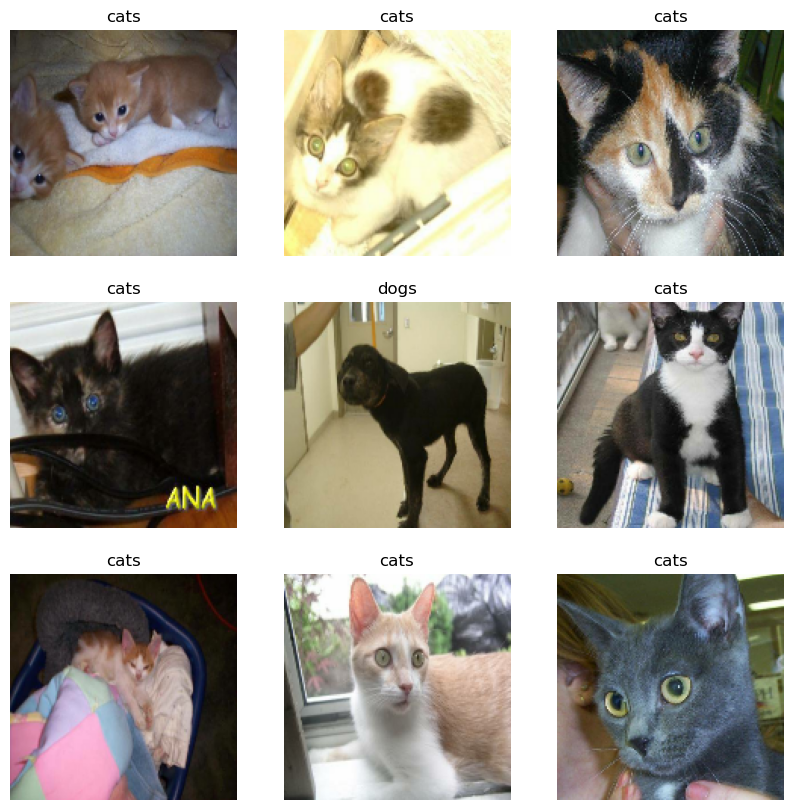

In [10]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [11]:
for image_batch, labels_batch in train_dataset:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(20, 150, 150, 3)
(20,)


In [12]:
list(train_dataset.take(1).as_numpy_iterator())[0][1].shape, list(train_dataset.take(1).as_numpy_iterator())[0][0].shape

((20,), (20, 150, 150, 3))

In [13]:
tf_2d = tf.constant(
    [[1, 2, 3],
     [1, 2, 3],
     [1, 2, 3]],
    dtype="float32",
)
tf_2d[:,-1:]

<tf.Tensor: shape=(3, 1), dtype=float32, numpy=
array([[3.],
       [3.],
       [3.]], dtype=float32)>

In [14]:
def resize_rescale(image, label):
    image = tf.cast(image, tf.float32)
    return tf.squeeze(image), tf.squeeze(tf.squeeze(label)[:, -1:])

In [15]:
train_data = (train_dataset
              .cache()
              .shuffle(buffer_size=512, reshuffle_each_iteration=True)
              .prefetch(tf.data.AUTOTUNE))

val_data = (val_dataset
              .cache()
              .shuffle(buffer_size=512, reshuffle_each_iteration=True)
              .prefetch(tf.data.AUTOTUNE))

In [16]:
list(train_data.take(1).as_numpy_iterator())[0][1].shape, list(train_data.take(1).as_numpy_iterator())[0][0].shape

((20,), (20, 150, 150, 3))

In [17]:
class CustomCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if (logs.get('val_binary_accuracy') >= 0.80):
            print("80% Accuracy is reached .......Hence Stopping")
            self.model.stop_training = True


# Giving call back for accuracy
callbacks = CustomCallback()

# Giving call back for EarlyStopping
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    min_delta=0.0001,
    patience=15,
    verbose=1,
    mode='auto',
    baseline=None,
    restore_best_weights=True
)

# Logging the losses and metrics data
filename = 'log.csv'
csv_logger = tf.keras.callbacks.CSVLogger(
    filename, separator=',', append=False)

# Changing Learning Rate with a Scheduler function


def schedule_func(epoch, lr):
    if epoch < 3:
        return lr
    else:
        return lr * tf.math.exp(-0.1)


lr_scheduler = tf.keras.callbacks.LearningRateScheduler(schedule_func)
lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_binary_accuracy',
    factor=0.1,
    patience=2,
    verbose=1,
    mode='auto',
    min_delta=0.0001,
    min_lr=0.0000001
)

# Saving the best model and its weights to given path
checkpoint_filepath = 'models/model_checkpoint'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
                                                                filepath=checkpoint_filepath,
                                                                verbose=1,
                                                                # save_weights_only=True,
                                                                save_best_only=True,
                                                                monitor='val_loss',
                                                                mode='auto'
                                                            )

In [18]:
import warnings
warnings.filterwarnings('ignore')

In [19]:
# Create a new model
model = create_model()
model.summary()



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 150, 150, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 74, 74, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 36, 36, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 34, 34, 128)      

In [20]:
# Constant for epochs
EPOCHS = 5

# Create a new model
model = create_model()

# Train the model
history = model.fit(
    train_data,
    steps_per_epoch=100,  # 2000 images = batch_size * steps
    epochs=EPOCHS,
    validation_data=val_data,
    validation_steps=50,  # 1000 images = batch_size * steps
    verbose=2,
    callbacks=[callbacks,
               early_stopping,
               csv_logger,
               lr_scheduler,
               model_checkpoint_callback])

Epoch 1/5

Epoch 1: val_loss improved from inf to 0.68504, saving model to models\model_checkpoint
INFO:tensorflow:Assets written to: models\model_checkpoint\assets


INFO:tensorflow:Assets written to: models\model_checkpoint\assets


100/100 - 45s - loss: 0.6924 - binary_accuracy: 0.5140 - val_loss: 0.6850 - val_binary_accuracy: 0.5660 - lr: 1.0000e-04 - 45s/epoch - 454ms/step
Epoch 2/5

Epoch 2: val_loss did not improve from 0.68504
100/100 - 34s - loss: 0.6764 - binary_accuracy: 0.5765 - val_loss: 0.6886 - val_binary_accuracy: 0.5290 - lr: 1.0000e-04 - 34s/epoch - 340ms/step
Epoch 3/5

Epoch 3: val_loss improved from 0.68504 to 0.65478, saving model to models\model_checkpoint
INFO:tensorflow:Assets written to: models\model_checkpoint\assets


INFO:tensorflow:Assets written to: models\model_checkpoint\assets


100/100 - 36s - loss: 0.6512 - binary_accuracy: 0.6210 - val_loss: 0.6548 - val_binary_accuracy: 0.6120 - lr: 1.0000e-04 - 36s/epoch - 360ms/step
Epoch 4/5

Epoch 4: val_loss improved from 0.65478 to 0.62281, saving model to models\model_checkpoint
INFO:tensorflow:Assets written to: models\model_checkpoint\assets


INFO:tensorflow:Assets written to: models\model_checkpoint\assets


100/100 - 37s - loss: 0.6219 - binary_accuracy: 0.6590 - val_loss: 0.6228 - val_binary_accuracy: 0.6490 - lr: 1.0000e-04 - 37s/epoch - 373ms/step
Epoch 5/5

Epoch 5: val_loss did not improve from 0.62281
100/100 - 34s - loss: 0.5840 - binary_accuracy: 0.6960 - val_loss: 0.6423 - val_binary_accuracy: 0.6530 - lr: 1.0000e-04 - 34s/epoch - 339ms/step


In [22]:
model.input

<KerasTensor: shape=(None, 150, 150, 3) dtype=float32 (created by layer 'rescaling_1_input')>

In [23]:
model.output

<KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'dense_3')>

In [41]:
train_generator.class_indices

{'cats': 0, 'dogs': 1}

In [42]:
train_dataset.class_names

['cats', 'dogs']

In [43]:
from tensorflow.keras.preprocessing import image

img_path = 'cat.jpg'
img_path = 'dog.jpg'
img = image.load_img(img_path, target_size=(150, 150))
x1 = image.img_to_array(img)
print(x1.shape)
x2 = np.expand_dims(x1, axis=0)
print(x2.shape)

(150, 150, 3)
(1, 150, 150, 3)


In [44]:
pred = model.predict(x2)

if pred <0.5:
    print("Cat")
else:
    print("Dog")

1/1 [==============================] - 0s 50ms/step
Cat


In [45]:
np.argmax([0.3,0.7])

1

In [22]:
# Constant for epochs
EPOCHS = 5

# Create a new model
model_2 = create_model()

# Train the model
history = model_2.fit(
      train_generator,
      steps_per_epoch=100,  # 2000 images = batch_size * steps
      epochs=EPOCHS,
      validation_data=validation_generator,
      validation_steps=50,  # 1000 images = batch_size * steps
      verbose=2,
    callbacks=[callbacks,
               early_stopping,
               csv_logger,
               lr_scheduler,
               model_checkpoint_callback])

Epoch 1/5
100/100 - 47s - loss: 0.6932 - binary_accuracy: 0.5185 - val_loss: 0.6887 - val_binary_accuracy: 0.5000 - 47s/epoch - 466ms/step
Epoch 2/5
100/100 - 43s - loss: 0.6892 - binary_accuracy: 0.5325 - val_loss: 0.6796 - val_binary_accuracy: 0.5160 - 43s/epoch - 433ms/step
Epoch 3/5
100/100 - 44s - loss: 0.6787 - binary_accuracy: 0.5675 - val_loss: 0.6564 - val_binary_accuracy: 0.6220 - 44s/epoch - 440ms/step
Epoch 4/5
100/100 - 45s - loss: 0.6682 - binary_accuracy: 0.5830 - val_loss: 0.6819 - val_binary_accuracy: 0.5660 - 45s/epoch - 453ms/step
Epoch 5/5
100/100 - 45s - loss: 0.6664 - binary_accuracy: 0.5880 - val_loss: 0.6253 - val_binary_accuracy: 0.6440 - 45s/epoch - 447ms/step


You will then visualize the loss and accuracy with respect to the training and validation set. You will again use a convenience function so it can be reused later. This function accepts a [History](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/History) object which contains the results of the `fit()` method you ran above.

In [23]:
history.history.keys()

dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])

In [24]:
import matplotlib.pyplot as plt

def plot_loss_acc(history):
  '''Plots the training and validation loss and accuracy from a history object'''
  acc = history.history['binary_accuracy']
  val_acc = history.history['val_binary_accuracy']
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(len(acc))
  plt.figure(figsize=(15,4))
  
  plt.subplot(1,2,1)
  plt.plot(epochs, acc, 'bo', label='Training accuracy')
  plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
  plt.title('Training and validation accuracy')

  plt.subplot(1,2,2)
  plt.plot(epochs, loss, 'bo', label='Training Loss')
  plt.plot(epochs, val_loss, 'b', label='Validation Loss')
  plt.title('Training and validation loss')
  plt.legend()
  
  plt.tight_layout()

  plt.show()

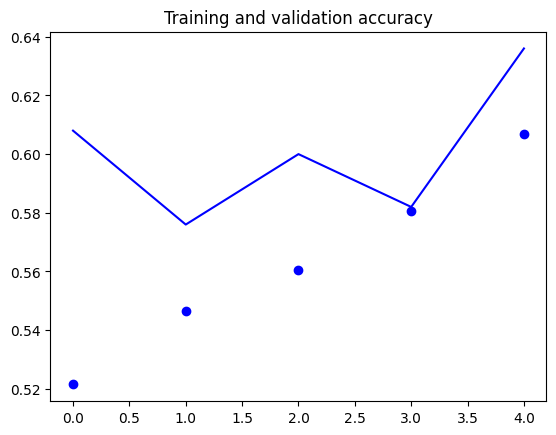

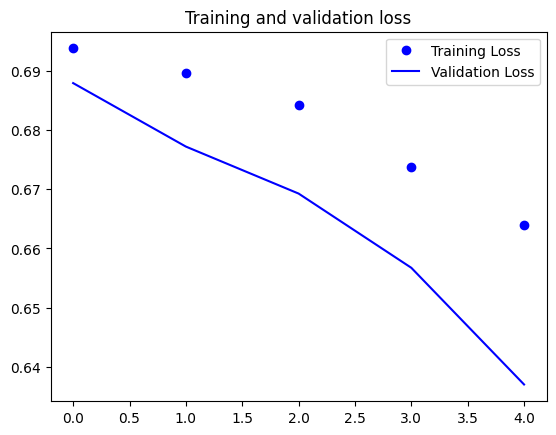

In [29]:
# Plot training results
plot_loss_acc(history)